# import library

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from PIL import Image
import math
import keras
import os
%matplotlib inline

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


# GPU

In [4]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

Thu Nov  9 06:54:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Check and Split Data

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

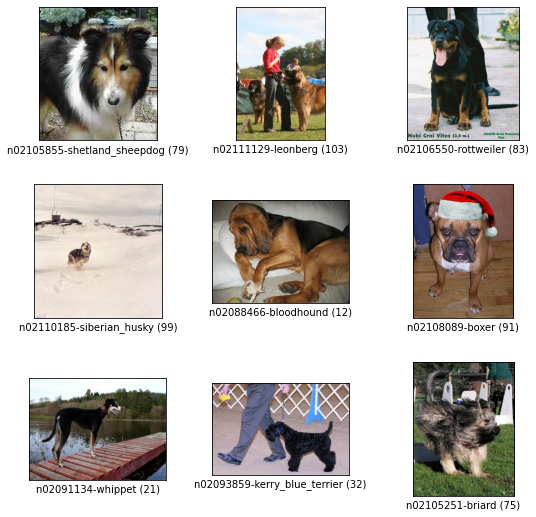

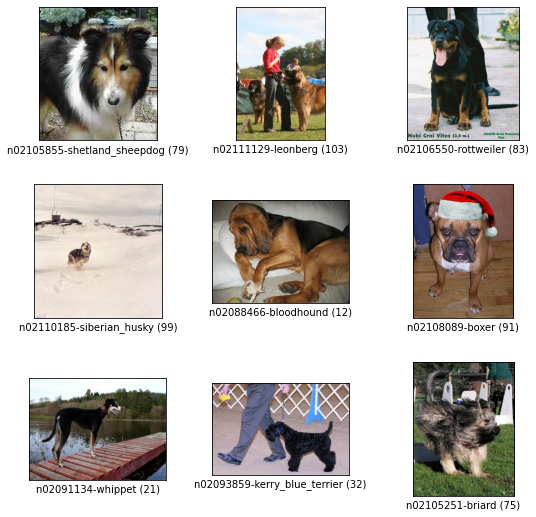

In [6]:
tfds.show_examples(ds_train, ds_info)

# Functions

In [7]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     degrees = tf.random.uniform((), minval=-20, maxval=20, dtype=tf.float32)
#     image = tfa.image.rotate(image, degrees * math.pi / 180, interpolation='BILINEAR')
#     crop_size = [int(224 * 0.8), int(224 * 0.8), 3]
#     image = tf.image.random_crop(image, size=crop_size)
#     image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False, with_cutmixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    elif not is_test and with_cutmixup:
        ds = ds.map(
            cutmixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# Load Model

In [8]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [9]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Train ds with augmentation, without augmention

In [10]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# Cutmix

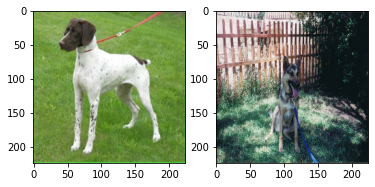

In [11]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(82, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(197, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


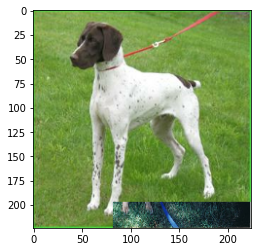

In [13]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [14]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.923589  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [15]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Train ds without aug + with cutmix and with aug + with cutmix

In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [15]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 167s 205ms/step - loss: 3.8219 - accuracy: 0.2111 - val_loss: 3.4270 - val_accuracy: 0.1941
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.9340 - accuracy: 0.4301 - val_loss: 1.6957 - val_accuracy: 0.5491
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6088 - accuracy: 0.5381 - val_loss: 1.2127 - val_accuracy: 0.6596
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.4048 - accuracy: 0.6019 - val_loss: 1.1797 - val_accuracy: 0.6725
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.2650 - accuracy: 0.6507 - val_loss: 1.3876 - val_accuracy: 0.6329
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1306 - accuracy: 0.6960 - val_loss: 1.3683 - val_accuracy: 0.6349
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0217 - accuracy: 0.7335 - val_loss: 1.2702 -

In [18]:
callback_list=[keras.callbacks.ModelCheckpoint(filepath="augmentation.h5",save_best_only=True)]

In [19]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    callbacks=callback_list,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 205ms/step - loss: 4.1826 - accuracy: 0.1258 - val_loss: 3.5714 - val_accuracy: 0.1916


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 3.4151 - accuracy: 0.2879 - val_loss: 1.7011 - val_accuracy: 0.5217
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 3.1289 - accuracy: 0.3617 - val_loss: 2.0088 - val_accuracy: 0.4688
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.9440 - accuracy: 0.4232 - val_loss: 1.4417 - val_accuracy: 0.5943
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.8233 - accuracy: 0.4564 - val_loss: 2.0268 - val_accuracy: 0.4714
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6884 - accuracy: 0.5072 - val_loss: 1.3082 - val_accuracy: 0.6383
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6079 - accuracy: 0.5346 - val_loss: 1.3372 - val_accuracy: 0.6353
Epoch 8/20
750/750 [==============================] - 153s 204ms/step - loss: 2.5230 - accuracy: 0.5532 - val_loss: 1.3914 -

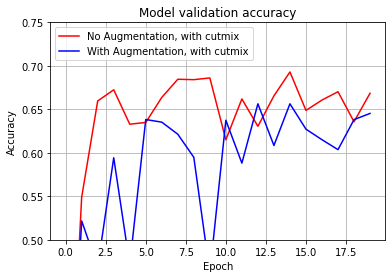

In [45]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation, with cutmix', 'With Augmentation, with cutmix'], loc='upper left')
plt.grid(True)
plt.ylim(0.5, 0.75)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# Mixup

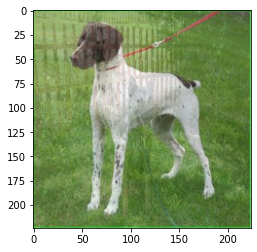

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.7706847
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.22931528 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

In [17]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [18]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Train ds without aug + with mixup and with aug + with mixup

In [36]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_mixup=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [37]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug_mixup = resnet50.fit(
    ds_train_no_aug_mixup, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 206ms/step - loss: 1.9130 - accuracy: 0.8227 - val_loss: 1.4991 - val_accuracy: 0.6458
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 1.8480 - accuracy: 0.8388 - val_loss: 1.7477 - val_accuracy: 0.5995
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 1.8128 - accuracy: 0.8447 - val_loss: 1.5570 - val_accuracy: 0.6346
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 1.7830 - accuracy: 0.8475 - val_loss: 1.4221 - val_accuracy: 0.6713
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 1.7876 - accuracy: 0.8442 - val_loss: 1.4112 - val_accuracy: 0.6695
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 1.7488 - accuracy: 0.8553 - val_loss: 1.5463 - val_accuracy: 0.6355
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 1.7322 - accuracy: 0.8583 - val_loss: 1.3784 -

In [38]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 205ms/step - loss: 2.1458 - accuracy: 0.7396 - val_loss: 1.8072 - val_accuracy: 0.5536
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1298 - accuracy: 0.7468 - val_loss: 1.8336 - val_accuracy: 0.5525
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0808 - accuracy: 0.7641 - val_loss: 1.4100 - val_accuracy: 0.6399
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0648 - accuracy: 0.7589 - val_loss: 1.3590 - val_accuracy: 0.6535
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0505 - accuracy: 0.7719 - val_loss: 1.4490 - val_accuracy: 0.6350
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0367 - accuracy: 0.7788 - val_loss: 1.3753 - val_accuracy: 0.6511
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0006 - accuracy: 0.7832 - val_loss: 1.3957 -

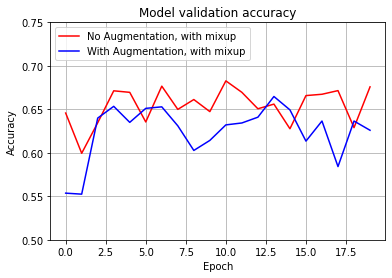

In [44]:
plt.plot(history_resnet50_no_aug_mixup.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation, with mixup', 'With Augmentation, with mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.5, 0.75)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# Train ds without any augmentaion and with only cutmix + mixup

In [19]:
def cutmixup(image, label, batch_size=16, img_size=224, num_classes=120):
    # Apply CutMix augmentation first
    mixed_imgs, mixed_labels = [], []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    # Convert lists to tensors and reshape them
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))

    # Now apply MixUp augmentation on the CutMix results
    mixed_imgs_final, mixed_labels_final = [], []

    for i in range(batch_size):
        image_a = mixed_imgs[i]
        label_a = mixed_labels[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = mixed_imgs[j]
        label_b = mixed_labels[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs_final.append(mixed_img)
        mixed_labels_final.append(mixed_label)

    # Convert lists to tensors and reshape them again
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs_final), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels_final), (batch_size, num_classes))

    return mixed_imgs, mixed_labels

# Check image and Data Preprocessing

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_any_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_cutmix_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

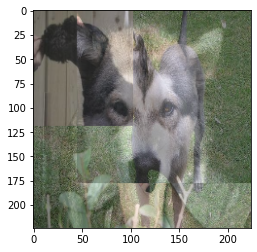

In [23]:
for i, (images, labels) in enumerate(ds_train_cutmix_mixup.take(1)):
    plt.imshow(images[0].numpy())
    plt.show()

In [39]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_any_aug = resnet50.fit(
    ds_train_no_any_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 158s 202ms/step - loss: 2.2135 - accuracy: 0.4417 - val_loss: 3.3127 - val_accuracy: 0.2194
Epoch 2/20
750/750 [==============================] - 151s 201ms/step - loss: 0.7054 - accuracy: 0.8088 - val_loss: 1.2511 - val_accuracy: 0.6370
Epoch 3/20
750/750 [==============================] - 151s 201ms/step - loss: 0.2108 - accuracy: 0.9567 - val_loss: 0.9410 - val_accuracy: 0.7232
Epoch 4/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0640 - accuracy: 0.9947 - val_loss: 0.9096 - val_accuracy: 0.7423
Epoch 5/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0261 - accuracy: 0.9993 - val_loss: 0.9045 - val_accuracy: 0.7449
Epoch 6/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0165 - accuracy: 0.9997 - val_loss: 0.9203 - val_accuracy: 0.7409
Epoch 7/20
750/750 [==============================] - 151s 201ms/step - loss: 0.0122 - accuracy: 0.9995 - val_loss: 0.9476 -

In [42]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix_mixup = aug_resnet50.fit(
    ds_train_cutmix_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 160s 203ms/step - loss: 3.8427 - accuracy: 0.2072 - val_loss: 3.2797 - val_accuracy: 0.2246
Epoch 2/20
750/750 [==============================] - 152s 203ms/step - loss: 2.9377 - accuracy: 0.4407 - val_loss: 1.5047 - val_accuracy: 0.5828
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 2.6187 - accuracy: 0.5372 - val_loss: 1.2061 - val_accuracy: 0.6642
Epoch 4/20
750/750 [==============================] - 152s 203ms/step - loss: 2.4114 - accuracy: 0.6030 - val_loss: 1.4354 - val_accuracy: 0.6093
Epoch 5/20
750/750 [==============================] - 152s 203ms/step - loss: 2.2521 - accuracy: 0.6610 - val_loss: 1.2406 - val_accuracy: 0.6685
Epoch 6/20
750/750 [==============================] - 152s 203ms/step - loss: 2.1176 - accuracy: 0.6975 - val_loss: 1.1945 - val_accuracy: 0.6811
Epoch 7/20
750/750 [==============================] - 152s 203ms/step - loss: 2.0293 - accuracy: 0.7258 - val_loss: 1.2976 -

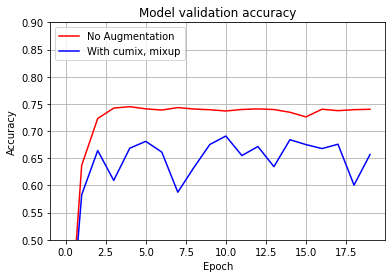

In [44]:
plt.plot(history_resnet50_no_any_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With cumix, mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.5, 0.90)
#plt.ylim(0.72, 0.76) 
plt.show()

# Train ds with simple augmentation

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_simple_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [25]:
EPOCH = 10

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_simple_aug = resnet50.fit(
    ds_train_simple_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
750/750 [==============================] - 208s 201ms/step - loss: 2.8867 - accuracy: 0.2911 - val_loss: 2.7852 - val_accuracy: 0.2987
Epoch 2/10
750/750 [==============================] - 151s 201ms/step - loss: 1.5722 - accuracy: 0.5510 - val_loss: 2.1699 - val_accuracy: 0.4262
Epoch 3/10
750/750 [==============================] - 151s 201ms/step - loss: 1.1014 - accuracy: 0.6796 - val_loss: 1.2892 - val_accuracy: 0.6270
Epoch 4/10
750/750 [==============================] - 151s 201ms/step - loss: 0.9200 - accuracy: 0.7346 - val_loss: 1.2819 - val_accuracy: 0.6298
Epoch 5/10
750/750 [==============================] - 151s 201ms/step - loss: 0.6224 - accuracy: 0.8213 - val_loss: 1.4483 - val_accuracy: 0.6047
Epoch 6/10
750/750 [==============================] - 151s 201ms/step - loss: 0.4566 - accuracy: 0.8698 - val_loss: 1.9155 - val_accuracy: 0.5290
Epoch 7/10
750/750 [==============================] - 151s 201ms/step - loss: 0.3307 - accuracy: 0.9130 - val_loss: 1.1980 -

# Train with every augmentation as much as I can

In [26]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_all_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [28]:
EPOCH = 10

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_all_aug = aug_resnet50.fit(
    ds_train_all_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 165s 204ms/step - loss: 3.5849 - accuracy: 0.3721 - val_loss: 1.4579 - val_accuracy: 0.6072
Epoch 2/10
750/750 [==============================] - 152s 203ms/step - loss: 3.5396 - accuracy: 0.3833 - val_loss: 1.4469 - val_accuracy: 0.6144
Epoch 3/10
750/750 [==============================] - 152s 203ms/step - loss: 3.5148 - accuracy: 0.3921 - val_loss: 1.3629 - val_accuracy: 0.6233
Epoch 4/10
750/750 [==============================] - 152s 203ms/step - loss: 3.4896 - accuracy: 0.4090 - val_loss: 1.5595 - val_accuracy: 0.5854
Epoch 5/10
750/750 [==============================] - 152s 203ms/step - loss: 3.4787 - accuracy: 0.4114 - val_loss: 1.3703 - val_accuracy: 0.6253
Epoch 6/10
750/750 [==============================] - 152s 203ms/step - loss: 3.4357 - accuracy: 0.4225 - val_loss: 1.2560 - val_accuracy: 0.6569
Epoch 7/10
750/750 [==============================] - 152s 203ms/step - loss: 3.4297 - accuracy: 0.4291 - val_loss: 1.4099 -

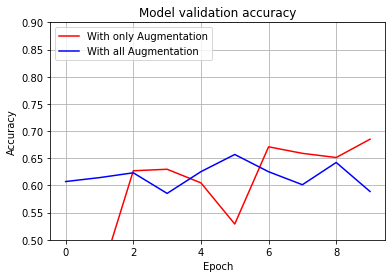

In [31]:
plt.plot(history_resnet50_simple_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_all_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With only Augmentation','With all Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.5, 0.90)
#plt.ylim(0.72, 0.76)
plt.show()

# Show everything on the same plot

In [ ]:
# plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r', label='No Augmentation, with cutmix')
# plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'b', label='With Augmentation, with cutmix')
# plt.plot(history_resnet50_no_aug_mixup.history['val_accuracy'], 'g', label='No Augmentation, with mixup')
# plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'orange', label='With Augmentation, with mixup')
# plt.plot(history_resnet50_no_any_aug.history['val_accuracy'], 'purple', label='No Augmentation, no mixup/cutmix')
# plt.plot(history_resnet50_cutmix_mixup.history['val_accuracy'], 'black', label='With Augmentation, with mixup and cutmix')
# plt.plot(history_resnet50_simple_aug.history['val_accuracy'], 'yellow', label='With Simple Augmentation')
# plt.plot(history_resnet50_all_aug.history['val_accuracy'], 'grey', label='With All Augmentation')

# plt.title('Model validation accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')
# plt.grid(True)

# plt.ylim(0.5, 0.90)

# plt.show()

!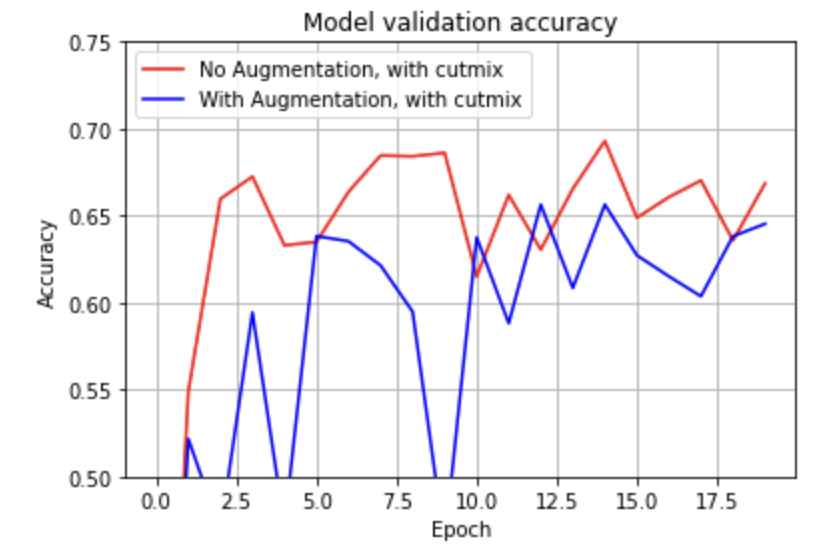
!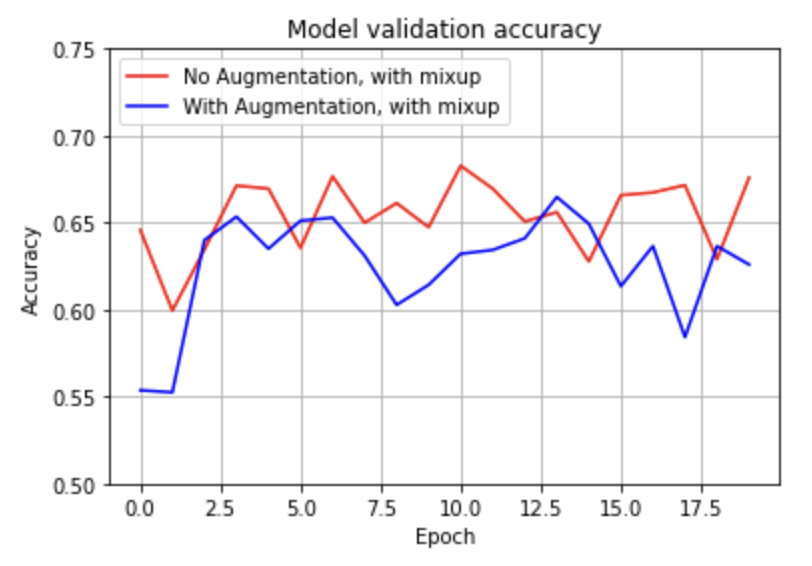<br>

!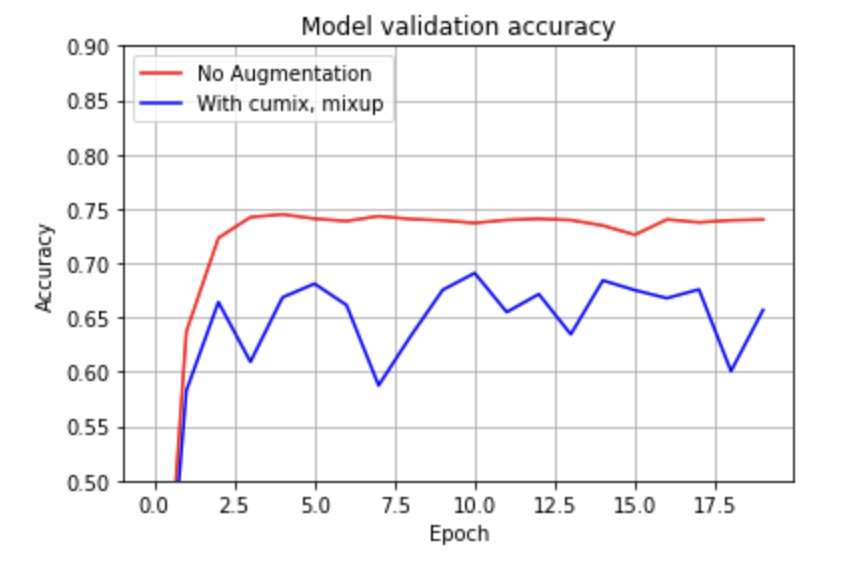
!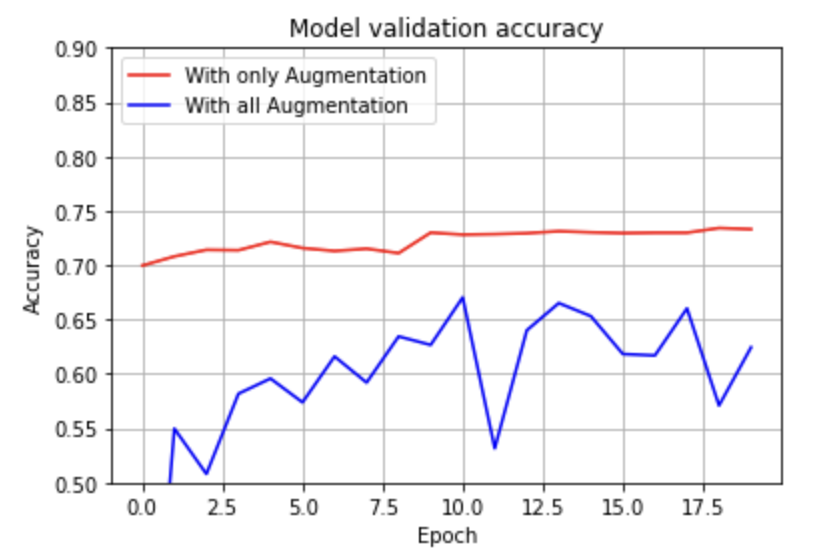

### Augmentation을 배웠던 것이 무상하게.. Augmentation이 없을때 가장 좋은 성능이 나왔다, 기본 Augmentation만 있을때, Accuracy가 0.75보다 높아짐을 기대했는데, 그렇지 않았다.

### 아마 다른 Augmentation을 추가 한 것에 원인이 있지 않을까 추측해볼 수 있었다.

### 참고로 Input 이미지 각도 조절이나, Crop은 이미지의 사이즈가 달라져서 기본 Augmentation에 추가 했다가 나중에 삭제했다.

### cutmix나 mixup을 적용하게 되면 그래프의 Validation Accuracy가 Epoch이 증가함에 따라 값의 변동이 심했다. 모든 augmentation을 적용한 모델은 최적화를 위한 학습이 더 필요해 보인다

!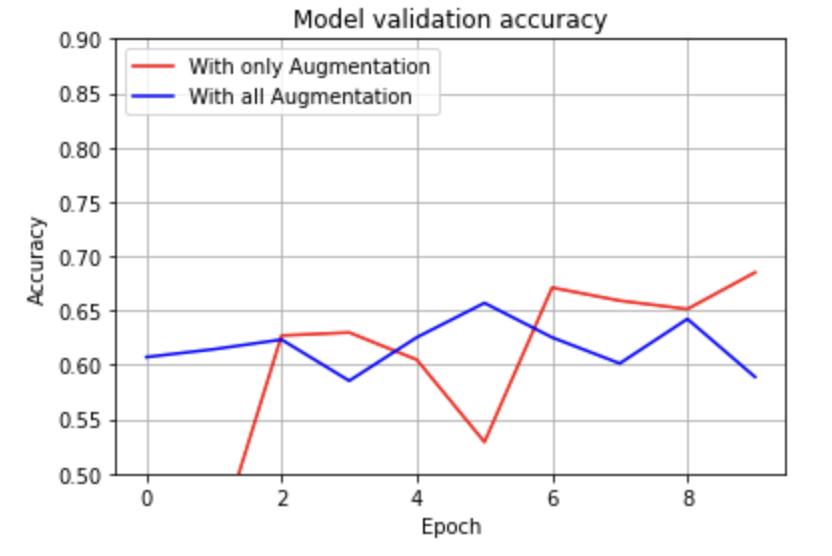
### 마지막 모델 수정 후 10번 epoch

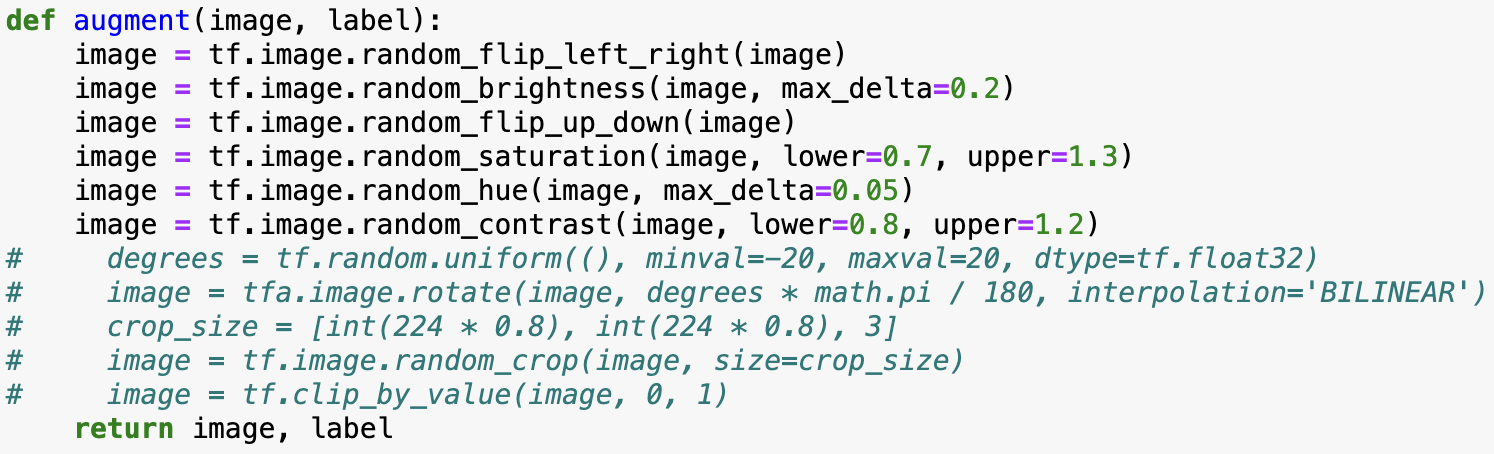